## Introduction

When I was taking Computer Architecture, I needed an FPGA for the class,
and a [Basys 3](https://store.digilentinc.com/basys-3-artix-7-fpga-trainer-board-recommended-for-introductory-users/)
in particular. In any other year, I would have probably borrowed it
from Cal Poly to take computer architecture. However,
due to the pandemic, I had to spend money and buy it myself.
That thing is $150 - it ain't cheap!

Now that class is over, I had this board and I wanted to do
something with it. I didn't want to do something that any
ordinary microcontroller could do because that's boring, in that case I would
just use a microcontroller. No, I wanted to make something that 
_requires_ a FPGA.

So, I thought of making a direct sampling software-defined
radio. It won't have a transmit function, only a receive
function, because I have no idea how to do power electronics.
Its main purpose would be basically as an ultra
wide band scanner (I'm thinking of trying to make it scan
a 50 MHz section all at once).

## Problem parameters

The FPGA has a **100 MHz internal clock** for most computations, and I
want to scan the spectrum of frequencies **between 125 and 175 MHz.**
Therefore, by the Nyquist-Shannon theorem, I will need at least
twice that - 325 MSPS (million samples per second) coming in.

I've figured out a possible way to get **400 MSPS at an 8 bit
resolution** into the FPGA. This involves going above 100 MHz, and 
this will likely be elaborated on in the future. But for now, we'll just
assume for now that that's the data stream coming in. So, every 100 MHz
clock, we get 4 x 8-bit samples. We are dealing with a theoretical
data rate of 3.2 Gbps, and _this_ is why we need an FPGA.

## Generating a "raw signal," and motivation

Let's make a signal with lots of different frequency components that we can use for experimenting with.

Bin size: 48.828 kHz


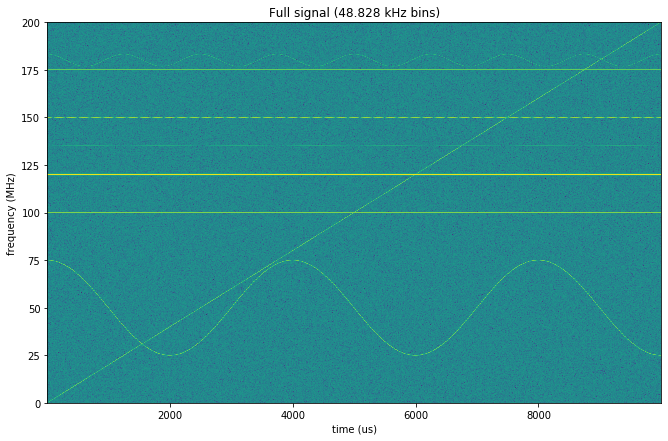

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Configuration so that y'all actually see this stuff
plt.rcParams['figure.figsize'] = [11, 7]

M_SAMPLES_PER_SECOND = 400
SAMPLES_PER_SECOND = M_SAMPLES_PER_SECOND * 1e6
NYQUIST = SAMPLES_PER_SECOND / 2
SIGNAL_LENGTH = 10e-3
FFT_SIZE = 4096

# Time domain (1 index = 1 sample at 400 MSPS)
time = np.linspace(0, SIGNAL_LENGTH, SIGNAL_LENGTH * SAMPLES_PER_SECOND)

def tone(x):
    return np.cos(x * time * 2 * np.pi)

def fm_tone(x, carrier, deviation):
    return np.cos(carrier * time * 2 * np.pi + deviation * np.sin(x * time * 2 * np.pi))

def am_tone(x, carrier):
    return (1 + np.cos(x * time * 2 * np.pi)) * np.cos(carrier * time * 2 * np.pi)

received_signal = 5 * tone(125e6)
received_signal += 5 * tone(175e6)
received_signal += 10 * am_tone(5e3, 150e6)
received_signal += fm_tone(100e3, 135e6, 0.25)

# Add in some unwanted tones
received_signal += 5 * tone(100e6)
received_signal += 100 * tone(120e6)
received_signal += 0.5 * fm_tone(800, 180e6, 4e3)
received_signal += 4 * fm_tone(250, 50e6, 1e5)

# An increasing frequency tone to act as an indicator
received_signal += 3 * np.cos((time * 100e6 / SIGNAL_LENGTH) * time * 2 * np.pi)

# Add in some noise for the heck of it
received_signal += np.random.normal(0, 1, len(time))

bin_size_0 = 1000 * M_SAMPLES_PER_SECOND / 2 / FFT_SIZE

plt.specgram(received_signal, FFT_SIZE, M_SAMPLES_PER_SECOND)
print(f'Bin size: {bin_size_0:02.3f} kHz')

plt.title(f"Full signal ({bin_size_0:02.3f} kHz bins)")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

50 kHz is really quite thick for a bin. If I recall correctly, narrowband FM on 
a Baofeng is 12.5kHz and it's even smaller for other radios. Plus, we have 
a ton of signals that we _don't_ want. We don't care about that big 
25-75 sine wave thingy, it's just noise that we'll end up discarding anyways.

This is the motivation behind preprocessing the signal. We can attempt to zoom in 
on the 125-175MHz range so that our FFT can be somewhat more precise.

## Shifting the signal downwards

### Bandpass

First, we apply a bandpass filter with cutoffs at 120MHz and 180MHz. They
are somewhat offset from the frequencies we want so that we have a little
buffer space at the ends.

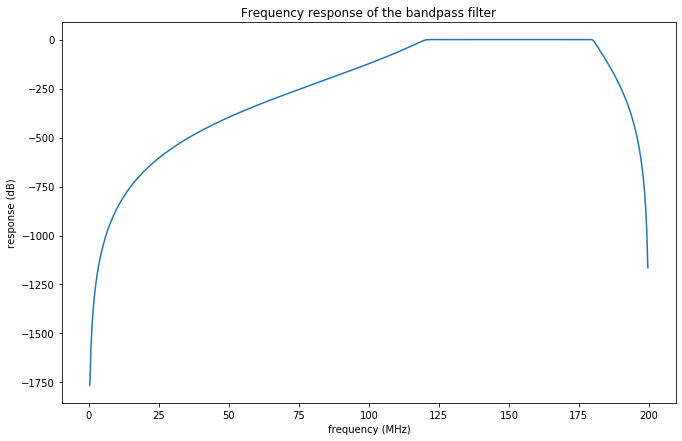

In [11]:
from scipy import signal

bp_filter = signal.butter(
    32,
    [120e6 / NYQUIST, 180e6 / NYQUIST],
    'band',
    analog=False,
    output='sos'
)
w, h = signal.sosfreqz(bp_filter, fs=400)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title("Frequency response of the bandpass filter")
plt.ylabel('response (dB)')
plt.xlabel('frequency (MHz)')
plt.show()

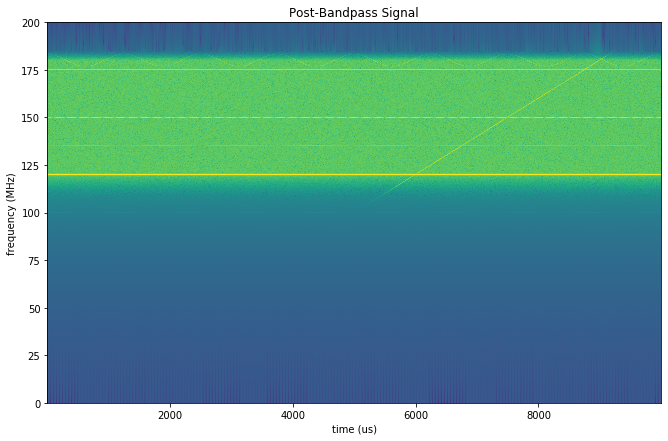

In [12]:
bp_sig = signal.sosfilt(bp_filter, received_signal)
plt.specgram(bp_sig, FFT_SIZE, M_SAMPLES_PER_SECOND)
plt.title("Post-Bandpass Signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

### Mixing for Shifting

Next, we mix with a 115MHz signal. For a signal with frequency $f$, this should
produce two signals, one at $f - 115\text{MHz}$, and the other reflected
at $115\text{MHz} - (f - 115\text{MHz})$.

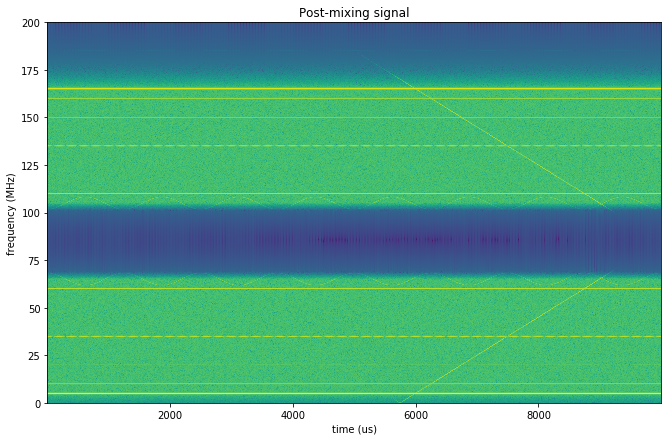

In [13]:
mixed = bp_sig * np.cos(115e6 * 2 * np.pi * time)

plt.specgram(mixed, FFT_SIZE, M_SAMPLES_PER_SECOND)
plt.title("Post-mixing signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

### Lowpass

We now perform a low pass to keep the low-frequency signal and get rid of its evil high-frequency twin.
The 10-60MHz range here is the equivalent of the original's 125-175MHz range, so we'll do a 65MHz 
lowpass.

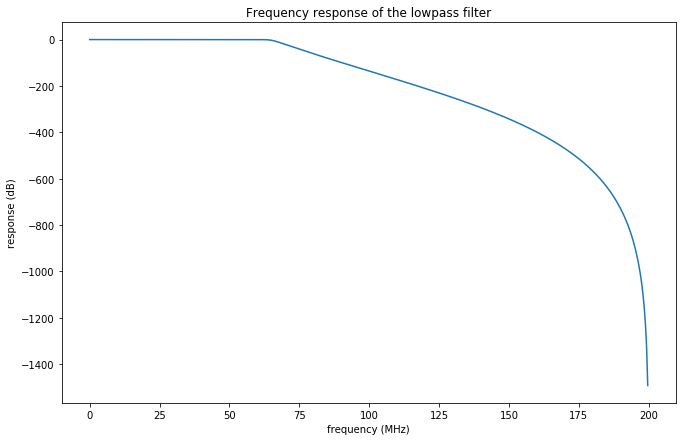

In [14]:
lp_filter = signal.butter(
    27,
    65e6 / NYQUIST,
    'lowpass',
    output='sos'
)
w, h = signal.sosfreqz(lp_filter, fs=400)
plt.plot(w, 20 * np.log10(abs(h)))
plt.title("Frequency response of the lowpass filter")
plt.ylabel('response (dB)')
plt.xlabel('frequency (MHz)')
plt.show()

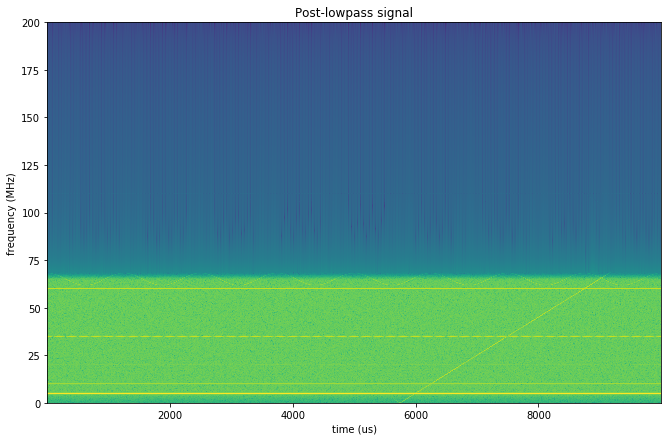

In [15]:
lp_sig = signal.sosfilt(lp_filter, mixed)
plt.specgram(lp_sig, FFT_SIZE, M_SAMPLES_PER_SECOND)
plt.title("Post-lowpass signal")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

### Decimation

Finally, we decimate to get rid of what we don't want. Decimating by a
factor of 3 means that the frequencies included here are between 0-67MHz
post-mixing, which is 120-177MHz on the original.

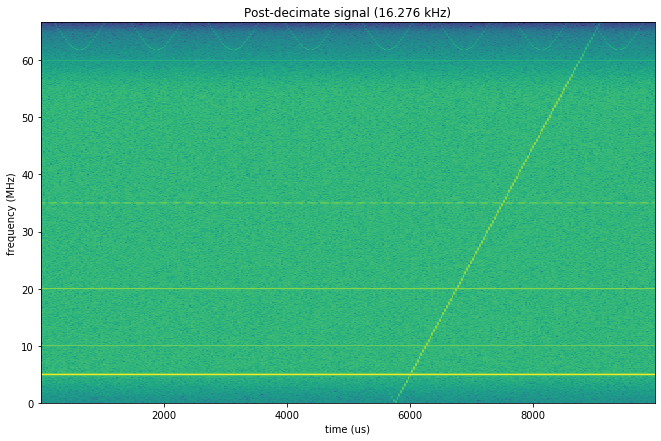

Bin size (no pre-processing): 48.828125 kHz
Bin size (with pre-processing): 16.276 kHz


In [16]:
decimate = signal.decimate(lp_sig, 3)
bin_size_1 = 1000 * (M_SAMPLES_PER_SECOND / 3) / 2 / FFT_SIZE

plt.specgram(decimate, FFT_SIZE, M_SAMPLES_PER_SECOND / 3)

plt.title(f"Post-decimate signal ({bin_size_1:02.3f} kHz)")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

print(f'Bin size (no pre-processing): {bin_size_0} kHz')
print(f'Bin size (with pre-processing): {bin_size_1:02.3f} kHz')

### Cutting off the edges

You can see how the sub-120 MHz signals get aliased in by the "checkmark"
over the 1500 tick. This is why we want padding below 125MHz and above
175MHz. However, the aliasing stays below 10 MHz on this spectrogram (125 MHz
on the original). So, we'll just zoom in on the center and pretend the
upper and lower bands don't exist and pretend the
axes are the correct "original" values.

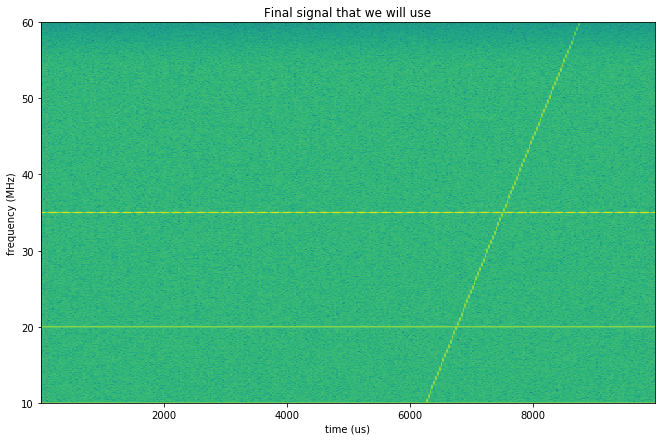

In [17]:
plt.specgram(decimate, FFT_SIZE, M_SAMPLES_PER_SECOND / 3)
plt.ylim([10, 60])
plt.title("Final signal that we will use")
plt.ylabel('frequency (MHz)')
plt.xlabel('time (us)')
plt.show()

## Conclusion

In this post we have designed a method of pre-processing a signal so that performing a FFT on it later will be more precise and have smaller bins. If I continue working on this project, I'll post updates and make a project page for it.

## License

Copyright (c) 2020 Astrid Yu

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.